In [1]:
import utils
import numpy as np
from openslide import open_slide
import os
import cv2
from shutil import rmtree
from tqdm.notebook import tqdm, trange
import re
import glob
from skimage.color import rgb2gray
import gc
import matplotlib.pyplot as plt
import pathlib

In [2]:
def extract_patch_from_center(
    slide, mask, cur_level,
    center_x, center_y,
    level1, level2, 
    patch_size, debug=False):
    """Extract 2 patches from same slide at 2 zoom levels 
    centered at same region
    Assert:
        level1 < level2: level1 has smaller downsample rate, level1 for zoomed-in version
    
    Args:
        slide (open_slide): open_slide object
        mask (open_slide): open_slide object
        cur_level (int): current level e.g. 7
        level1, level2 (int): e.g. 4, 5
        center_x, center_y (int): coordinates of center w.r.t. current level in computer vision
        patch_size (int): size of the patch w.r.t. level1, int, eg 299, should be same for all levels
        debug (bool): whether to use debug mode

    Returns:
        a dictionary that has 4 k-v pairs
        slide images are 3D arrays
        mask images are 2D arrays
        or an empty dictionary
    """
    assert level1 < level2 
    
    ### Define some constant variables ###
    curlevel_downrate = int(slide.level_downsamples[cur_level])
    level1_downrate = int(slide.level_downsamples[level1])
    level2_downrate = int(slide.level_downsamples[level2])
    # careful, level_dimensions give dimensions
    # w.r.t. x, y in computer vision
    # so (736, 868) means (w, h) in numpy arrays
    level1_w, level1_h = slide.level_dimensions[level1]
    level2_w, level2_h = slide.level_dimensions[level2]
    
    ### Do some maths ###
    center_x0, center_y0 = int(center_x * curlevel_downrate), int(center_y * curlevel_downrate) # w.r.t level 0
    
    # on zoom level 1
    center_x1, center_y1 = center_x0 // level1_downrate, center_y0 // level1_downrate
    start_x1, start_y1 = center_x1 - patch_size // 2, center_y1 - patch_size // 2
    end_x1, end_y1 = start_x1 + patch_size, start_y1 + patch_size
    start_x10, start_y10 = int(start_x1 * level1_downrate), int(start_y1 * level1_downrate)
    
    # on zoom level 2
    center_x2, center_y2 = center_x0 // level2_downrate, center_y0 // level2_downrate
    start_x2, start_y2 = center_x2 - patch_size // 2, center_y2 - patch_size // 2 # size on 2 zoom levels are equal
    end_x2, end_y2 = start_x2 + patch_size, start_y2 + patch_size
    start_x20, start_y20 = int(start_x2 * level2_downrate), int(start_y2 * level2_downrate)
    
    ### Validate and Extract Patch ### 
    if start_x1 < 0 or start_y1 < 0:
        return {}
    if start_x2 < 0 or start_y2 < 0:
        return {}
    if end_x1 > level1_w or end_y1 > level1_h:
        return {}
    if end_x2 > level2_w or end_y2 > level2_h:
        return {}
    
    level1_patch = utils.read_slide(slide, start_x10, start_y10, level1, patch_size, patch_size)
    level2_patch = utils.read_slide(slide, start_x20, start_y20, level2, patch_size, patch_size)
    
    level1_mask = utils.read_slide(mask, start_x10, start_y10, level1, patch_size, patch_size)[:,:,0]
    level2_mask = utils.read_slide(mask, start_x20, start_y20, level2, patch_size, patch_size)[:,:,0]
    
    if debug:
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(level1_patch)
        axs[0].set_title(f"Zoom Level {level1}")
        axs[1].imshow(level2_patch)
        axs[1].set_title(f"Zoom Level {level2}")
        plt.show()

    res = {}
    res['level1_patch'] = level1_patch
    res['level2_patch'] = level2_patch
    res['level1_mask'] = level1_mask
    res['level2_mask'] = level2_mask
    return res

(764, 1684)


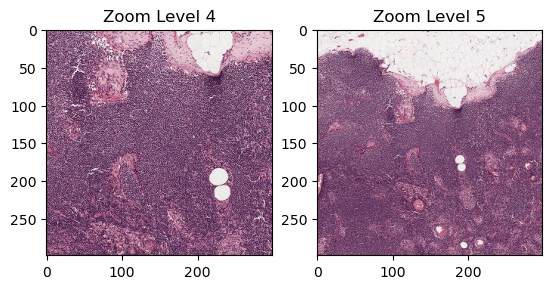

In [3]:
# verify
slide_path = "TIFs/trainingTIFs/tumor_012.tif"
mask_path = "TIFs/trainingTIFs/tumor_012_mask.tif"

args = {
    "slide": open_slide(slide_path),
    "mask": open_slide(mask_path),
    "cur_level": 7,
    "level1": 4,
    "level2": 5,
    "center_x": 400,
    "center_y": 900,
    "patch_size": 299,
    "debug": True,
}

print(open_slide(slide_path).level_dimensions[7])
res = extract_patch_from_center(**args)

In [4]:
def find_slide_number(slide_path: str) -> int:
    m = re.search("tumor_([\d]+)", slide_path)
    if m:
        return m.group(1)

In [5]:
def extract_patches_to_dir(
    slide_path, mask_path, cur_level, level1, level2, input_size, sample_size,
    zoom1_patch_normal_outdir, zoom1_patch_tumor_outdir, 
    zoom1_mask_normal_outdir, zoom1_mask_tumor_outdir,
    zoom2_patch_normal_outdir, zoom2_patch_tumor_outdir,
    zoom2_mask_normal_outdir, zoom2_mask_tumor_outdir) -> None:
    """Extract patches from im to dir
    1. Assume we will extract patches from the entire image at 2 zoom levels
    2. focus on level1
    3. randomly select indices that belong to normal/tumor
    
    Idea:
    1. find all coordinates on cur_level where there are tumor
    2. find all related coordinates on level1 and level2 where there are tumor
    3. do some preprocessing on those coordinates
    4. take a sample size of tumor/normal
    5. extract patch and save to directories
    
    Failed Implementation:
    1. slide through the image: too slow
    2. not specifying sample size: run through entire image, slow
    
    Args:
        slide_path (str): path to slide .tif image
        mask_path (str): path to mask .tif image
        cur_level (int): current level
        level1 (int): zoom level 1, zoomed-in level
        level2 (int): zoom level 2, zoomed-out level
        input_size (int): shape of the input eg 299
        sample_size (int): number of patches to create
    """
    def generate_args(slide, mask, x, y):
        args = {
            "slide": slide,
            "mask": mask,
            "cur_level": cur_level,
            "level1": level1,
            "level2": level2,
            "center_x": x,
            "center_y": y,
            "patch_size": input_size,
            "debug": False,
        }
        return args
    
    def gen_outdir(level1slide_out, level1mask_out, level2slide_out, level2mask_out) -> dict:
        outdirs = {
            "level1_slide": level1slide_out,
            "level1_mask": level1mask_out,
            "level2_slide": level2slide_out,
            "level2_mask": level2mask_out
        }
        return outdirs
    
    def save_patch(dirs, category, cutted_patch, counter, slide_number):
        out_images = [cutted_patch['level1_patch'], cutted_patch['level1_mask'], cutted_patch['level2_patch'], cutted_patch['level2_mask']]
        out_dirs = [dirs['level1_slide'], dirs['level1_mask'], dirs['level2_slide'], dirs['level2_mask']]
        for image, path in list(zip(out_images, out_dirs)):
            if image.ndim == 3:
                cv2.imwrite(f"{path}/{slide_number}_{category}_{counter}.png", image)
            elif image.ndim == 2:
                np.save(f"{path}/{slide_number}_{category}_{counter}.npy", image)
                
    def has_tumor_at_center(mask):
        """Return True if the center 128 x 128 region of mask
        has tumor (pixel=1)"""
        h, w = mask.shape
        start_r = h // 2 - 128 // 2
        end_r = start_r + 128
        start_c = w // 2 - 128 // 2
        end_c = start_c + 128
        mask_slice = mask[start_r:end_r, start_c:end_c]
        return np.count_nonzero(mask_slice) >= 1
    
    
    assert level1 < level2
    ### Input Block ### 
    slide = open_slide(slide_path)
    slide_number = find_slide_number(slide_path)
    mask = open_slide(mask_path)
    mask_curlevel = utils.read_entire_slide(mask, cur_level)[:,:,0]
    slide_curlevel = utils.read_entire_slide(slide, cur_level)
    slide_curlevel_gray = rgb2gray(slide_curlevel)
    print(f"Processing slide {slide_number}...")
    
    ### Find all coordinates that are tumor in cur_level ###
    tumor_indices = np.transpose(np.where((mask_curlevel == 1)))
    normal_indices = np.transpose(np.where((mask_curlevel == 0) & (slide_curlevel_gray <= 0.8)))
    print(f"Length of tumor indices: {len(tumor_indices)}")
    print(f"Length of normal indices: {len(normal_indices)}")
    # divide by sample size so that we can go through 
    # all tumor indices evenly
    tumor_step = len(tumor_indices) // sample_size if len(tumor_indices) > sample_size else 1
    # for normal, shrink step size by 2
    # because we need to allow a big enough space to collect samples
    normal_step = len(normal_indices) // sample_size // 2
    print("Finished generating indices! Now begin cutting slices...")

    ### Cutting Patches ### 
    tumor_count, normal_count = 0, 0
    for i in tqdm(range(0, len(tumor_indices), tumor_step)):
        if tumor_count < sample_size:
            y, x = tumor_indices[i]
            args = generate_args(slide, mask, x, y)
            cutted_patch = extract_patch_from_center(**args)
            if cutted_patch:
                outdirs = gen_outdir(zoom1_patch_tumor_outdir, zoom1_mask_tumor_outdir, zoom2_patch_tumor_outdir, zoom2_mask_tumor_outdir)
                save_patch(outdirs, "tumor", cutted_patch, tumor_count, slide_number)
                tumor_count += 1
        else:
            break

    for i in tqdm(range(0, len(normal_indices), normal_step)):
        if normal_count < sample_size:
            y, x = normal_indices[i]
            args = generate_args(slide, mask, x, y)
            cutted_patch = extract_patch_from_center(**args)
            if cutted_patch:
                # for normal, needs extra layer of check
                # because if the center coordinate is not tumor
                # the center region might still contain tumor cells
                mask_level1, mask_level2 = cutted_patch['level1_mask'], cutted_patch['level2_mask']
                if not has_tumor_at_center(mask_level1) and not has_tumor_at_center(mask_level2):
                    outdirs = gen_outdir(zoom1_patch_normal_outdir, zoom1_mask_normal_outdir, zoom2_patch_normal_outdir, zoom2_mask_normal_outdir)
                    save_patch(outdirs, "normal", cutted_patch, normal_count, slide_number)
                    normal_count += 1
        else:
            break

    gc.collect()
    print(f"Finished slide {slide_number}!")
    print(f"Processed {tumor_count} tumor slides and {normal_count} normal slides")

In [6]:
args = {
    "slide_path": "TIFs/trainingTIFs/tumor_084.tif",
    "mask_path": "TIFs/trainingTIFs/tumor_084_mask.tif",
    "cur_level": 5,
    "level1": 2,
    "level2": 3,
    "input_size": 299,
    "sample_size": 1000,
    "zoom1_patch_normal_outdir": "expTraining/zoom1/slides/normal",
    "zoom1_patch_tumor_outdir": "expTraining/zoom1/slides/tumor",
    "zoom1_mask_normal_outdir": "expTraining/zoom1/masks/normal", 
    "zoom1_mask_tumor_outdir": "expTraining/zoom1/masks/tumor",
    "zoom2_patch_normal_outdir": "expTraining/zoom2/slides/normal", 
    "zoom2_patch_tumor_outdir": "expTraining/zoom2/slides/tumor",
    "zoom2_mask_normal_outdir": "expTraining/zoom2/masks/normal", 
    "zoom2_mask_tumor_outdir": "expTraining/zoom2/masks/tumor",
}

In [7]:
def reset_directories(
    zoom1_patch_normal_outdir, zoom1_patch_tumor_outdir, zoom1_mask_normal_outdir, zoom1_mask_tumor_outdir, 
    zoom2_patch_normal_outdir, zoom2_patch_tumor_outdir, zoom2_mask_normal_outdir, zoom2_mask_tumor_outdir):
    dirs = [zoom1_patch_normal_outdir, 
            zoom1_patch_tumor_outdir, 
            zoom1_mask_normal_outdir, 
            zoom1_mask_tumor_outdir,
            zoom2_patch_normal_outdir,
            zoom2_patch_tumor_outdir,
            zoom2_mask_normal_outdir,
            zoom2_mask_tumor_outdir]
    for d in dirs:
        rmtree(d)
        os.makedirs(d)
    print("Done")

In [ ]:
dirs = {
    "zoom1_patch_normal_outdir": "expTraining/zoom1/slides/normal",
    "zoom1_patch_tumor_outdir": "expTraining/zoom1/slides/tumor",
    "zoom1_mask_normal_outdir": "expTraining/zoom1/masks/normal", 
    "zoom1_mask_tumor_outdir": "expTraining/zoom1/masks/tumor",
    "zoom2_patch_normal_outdir": "expTraining/zoom2/slides/normal", 
    "zoom2_patch_tumor_outdir": "expTraining/zoom2/slides/tumor",
    "zoom2_mask_normal_outdir": "expTraining/zoom2/masks/normal", 
    "zoom2_mask_tumor_outdir": "expTraining/zoom2/masks/tumor"
}

reset_directories(**dirs)

In [8]:
extract_patches_to_dir(**args)

Processing slide 084...
Length of tumor indices: 31914
Length of normal indices: 1200872
Finished generating indices! Now begin cutting slices...


  0%|          | 0/1030 [00:00<?, ?it/s]

  0%|          | 0/2002 [00:00<?, ?it/s]

Finished slide 084!
Processed 1000 tumor slides and 1000 normal slides


In [9]:
def remove_ipynb_checkpoints():
    res = pathlib.Path('expTraining').glob('**/*.ipynb_checkpoints')
    for f in res:
        print(f)
        shutil.rmtree(f)
    print("Done")

In [10]:
remove_ipynb_checkpoints()

Done
